In [86]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [98]:
import os
import glob

from pandas.api.types import CategoricalDtype

HOME = "/home/kwatchar3/spauq-home/spauq/expt/degradation/timit/results-2s/lpfpan"

results = glob.glob(os.path.join(HOME, "*.csv"))

print(results)

dfs = []

for r in results:
    df = pd.read_csv(r).rename(columns={'Unnamed: 0': 'filename', 'Unnamed: 1': 'lpf', 'Unnamed: 2': 'est_pan'})
    # df = pd.read_csv(r).rename(columns={'Unnamed: 0': 'filename', 'Unnamed: 1': 'est_pan'})
    dfs.append(df)
    
df = pd.concat(dfs)

# df['ref_pan'] = df['ref_pan'].apply(lambda x: np.round(x*10)/10)
df['est_pan'] = df['est_pan'].apply(lambda x: np.round(x*10)/10)
df['lpf'] = df['lpf'].apply(lambda x: int(np.round(x)))
# df['pan_err'] = df['est_pan'] - df['ref_pan']

df = df[df.lpf >= 256]

df0 = df.copy()

['/home/kwatchar3/spauq-home/spauq/expt/degradation/timit/results-2s/lpfpan/lpfpan.csv']


/tmp/ipykernel_993868/3419915390.py:10: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(w), 20*np.log10(np.abs(h)))
/tmp/ipykernel_993868/3419915390.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log2(w), 20*np.log10(np.abs(h)))


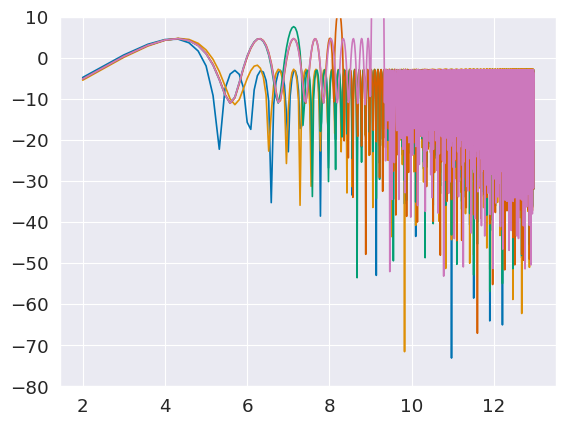

In [88]:
from scipy import signal as sps

# cutoff = 64
fs = 16000
f, ax = plt.subplots()
for cutoff in [32, 64, 128, 256, 512]:
    b = sps.remez(512, [0, cutoff, cutoff * np.power(2, 1/3), 8000], [1, 0], fs=fs, type="hilbert")
    w, h = sps.freqz(b, [1], worN=2000, fs=fs)

    plt.plot(np.log2(w), 20*np.log10(np.abs(h)))
plt.ylim([-80, 10])
plt.show()

In [89]:
125 * np.power(2, np.linspace(0, 6, 13))

array([ 125.        ,  176.7766953 ,  250.        ,  353.55339059,
        500.        ,  707.10678119, 1000.        , 1414.21356237,
       2000.        , 2828.42712475, 4000.        , 5656.85424949,
       8000.        ])

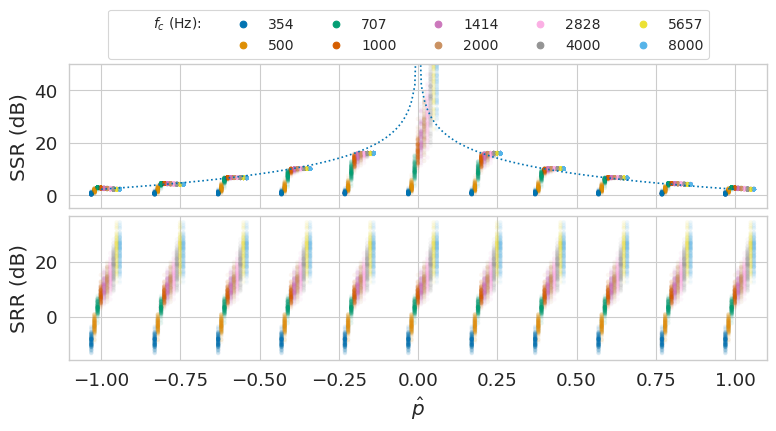

In [110]:
df = df0.copy()

p = np.concatenate([np.linspace(-1, 1, 100)])

def theoretical_ssr(p, upper, p0=0):
    if upper:
        t = np.sin(0.25 * np.pi * (p+1)) * np.sin(0.25 * np.pi * (p0+1)) * (1 - -1)
    else:
        t = np.sin(0.25 * np.pi * (p+1)) * np.sin(0.25 * np.pi * (p0+1)) * 0
    ssr = -10*np.log10(2 - 2 * np.cos(0.25 * np.pi * (p-p0)) + t)
    
    return ssr


sns.set("paper", "whitegrid", "colorblind", font_scale=1.5)
f, axs = plt.subplots(2, 1, figsize=(8,4))


ax = axs[0]
palette = sns.color_palette("colorblind", n_colors=len(df.lpf.unique()))

dmax = 32

dfm = df.groupby(['lpf', 'est_pan']).median(numeric_only=True).reset_index()


df['est_pan'] = df[['lpf', 'est_pan']].apply(lambda r: r.est_pan + 0.2 * ((np.log2(r.lpf)-10 if r.lpf > 0 else 0))/10, axis=1)
# sns.scatterplot(df, y='SSR', x='est_pan', hue='lpf', palette="colorblind", ax=ax, alpha=0.005, edgecolor="none")
sns.scatterplot(df, y='SSR', x='est_pan', hue='lpf', palette="colorblind", ax=ax, edgecolor="none", alpha=0.05, s=10)
h, l = ax.get_legend_handles_labels()

# kwargs = dict(ax=ax, linestyle='-.', linewidth=1, zorder=5)
# sns.lineplot(dfm, y='SSR', x='est_pan', hue='lpf', palette=palette, **kwargs)
# sns.lineplot(dfm[((dfm.lpf==0) & (dfm.est_pan < 0))], y='SSR', x='est_pan', hue='lpf', palette=[palette[0]], **kwargs)
# sns.lineplot(dfm[((dfm.lpf==0) & (dfm.est_pan > 0))], y='SSR', x='est_pan', hue='lpf', palette=[palette[0]], **kwargs)
p = np.concatenate([np.linspace(-1, -1e-4, 100),np.linspace(1e-4, 1, 100)])
ssr0 = theoretical_ssr(p, 0)
# ssr1 = theoretical_ssr(p, 1)
# ax.fill_between(p, ssr1, ssr0, zorder=1, edgecolor="none", color="gray", alpha=0.2)
sns.lineplot(x=p, y=ssr0, ls=":", ax=ax)
xlim = [-1.1, 1.1]
ax.set(ylim=[-5, 50], ylabel='SSR (dB)', xlim=xlim, xticklabels=[], xlabel=None)

ax.legend().remove()
h = 2*[plt.plot([], marker="", ls="")[0]] + h
l = ['$f_c$ (Hz):', ""] + l
f.legend(h, l, loc='upper center', fontsize=10, ncols=6, bbox_to_anchor=(0.525, 1.1))

ax = axs[1]
sns.scatterplot(df, y='SRR', x='est_pan', hue='lpf', palette="colorblind", ax=ax, edgecolor="none", alpha=0.05, s=10, legend=False)
ax.set(ylabel='SRR (dB)', xlabel='$\hat{p}$', xlim=xlim)#, ylim=[-10, 30])

plt.tight_layout()
f.align_ylabels(axs)
f.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig("figs/lpfpan.pdf", bbox_inches='tight')

plt.show()